In [58]:
import pandas as pd
import numpy as np
from sklearn import *
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns

In [66]:
raw = pd.read_csv("full_chtol.csv")
df = raw.drop(columns=["Unnamed: 0","collectDate"])
df = df.dropna()
df.shape

(128, 43)

In [67]:
split = 0.85

In [68]:
df = df.drop(columns="siteID")#[df['siteID']=='BARC']
tr = df[:int(len(df)*split)]
te = df[int(len(df)*split):]
x = df.drop(columns=["adjAshFreeDryMass"]).values
y = df['adjAshFreeDryMass'].values
seqxtr,seqytr = tr.drop(columns=["adjAshFreeDryMass"]),tr['adjAshFreeDryMass']
seqxte,seqyte = te.drop(columns=["adjAshFreeDryMass"]),te['adjAshFreeDryMass']

ranxtr,ranxte,ranytr,ranyte = sklearn.model_selection.train_test_split(x,y,test_size=0.15)

In [69]:
sig = pd.read_csv("signifCHTOL").drop(columns="Unnamed: 0")
sig = sig.drop(columns="siteID")#[sig['siteID']=='BARC']
sigtr = sig[:int(len(sig)*split)]
sigte = sig[int(len(sig)*split):]
sigx = sig.drop(columns="adjAshFreeDryMass")
sigy = sig['adjAshFreeDryMass']
seqsigxtr, seqsigytr = sigtr.copy().drop(columns='adjAshFreeDryMass'),sigtr['adjAshFreeDryMass']
seqsigxte, seqsigyte = sigte.copy().drop(columns='adjAshFreeDryMass'),sigte['adjAshFreeDryMass']

ransigxtr,ransigxte,ransigytr,ransigyte = sklearn.model_selection.train_test_split(
    sigx,sigy,test_size=0.15)

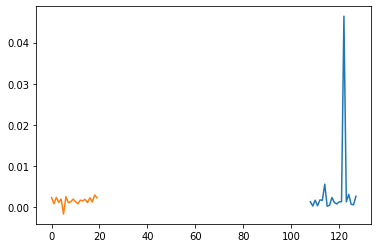

In [77]:
test = sklearn.linear_model.Ridge()
test.fit(seqxtr,seqytr)
plt.plot(seqyte)
plt.plot(test.predict(seqxte))

In [33]:
def regen_data():
    ranxtr,ranxte,ranytr,ranyte = sklearn.model_selection.train_test_split(x,y,test_size=0.15)
    ransigxtr,ransigxte,ransigytr,ransigyte = sklearn.model_selection.train_test_split(
        sigx,sigy,test_size=0.15)
    data = [("seq",(seqxtr,seqytr),(seqxte,seqyte)),
        ("ran",(ranxtr,ranytr),(ranxte,ranyte)),
        ("sig seq",(seqsigxtr,seqsigytr), (seqsigxte,seqsigyte)),
        ("sig ran",(ransigxtr,ransigytr), (ransigxte,ransigyte))]
    return data

In [34]:
data = [("seq",(seqxtr,seqytr),(seqxte,seqyte)),
        ("ran",(ranxtr,ranytr),(ranxte,ranyte)),
        ("sig seq",(seqsigxtr,seqsigytr), (seqsigxte,seqsigyte)),
        ("sig ran",(ransigxtr,ransigytr), (ransigxte,ransigyte))]

In [35]:
models = {}
models['ols linreg'] = sklearn.linear_model.LinearRegression()
models['ridge'] = sklearn.linear_model.Ridge()
models['lasso'] = sklearn.linear_model.Lasso()
models['elastic net'] = sklearn.linear_model.ElasticNet()
models['support vector'] = sklearn.svm.SVR()
models['decision tree'] = sklearn.tree.DecisionTreeRegressor()
models['neural net'] = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=(1000), max_iter=1000)

In [36]:
labels = {x:[] for x in list(models)}
labels['datatype'] = []

In [37]:
results = pd.DataFrame(labels)
for i in range(10):
    data = regen_data()
    print(f"trial {i+1}/{50}")
    for d in data:
        dtype = d[0]
        xtr,ytr = d[1]
        xte,yte = d[2]
        scaler = sklearn.preprocessing.MinMaxScaler()
        xtr = scaler.fit_transform(xtr)
        xte = scaler.fit_transform(xte)
        row = {}
        for modname in models:
            mod = models[modname]
            mod.fit(xtr,ytr)
            p = mod.predict(xte)
            percerror = np.mean(np.abs(p-yte)/yte)
            row[modname] = percerror
        row['datatype'] = dtype
        results = results.append(row,ignore_index=True)
print('done')

trial 1/50
trial 2/50
trial 3/50
trial 4/50
trial 5/50
trial 6/50
trial 7/50
trial 8/50
trial 9/50
trial 10/50
done


In [38]:
avged = results.groupby("datatype").mean()
avged

ols linreg      ridge      lasso  elastic net  support vector  \
datatype                                                                  
ran        12.745418  11.227599  10.385507    10.385507       24.820474   
seq         0.660011   0.645243   0.802972     0.802972        0.913810   
sig ran    15.988651  10.662042  11.215450    11.215450       26.784289   
sig seq     0.821105   0.813228   0.802972     0.802972        0.913810   

          decision tree  neural net  
datatype                             
ran           25.532749   76.464123  
seq            1.117294  112.290005  
sig ran       24.844215   62.338463  
sig seq        0.870125   37.880457

In [13]:
avged = avged.loc[['ran', 'sig ran', 'seq', 'sig seq']]

In [14]:
avged.index = ["random","random w/ signif vars","sequential","sequential w/ signif vars"]

In [15]:
sns.set_style("white")
sns.set_palette("GnBu")

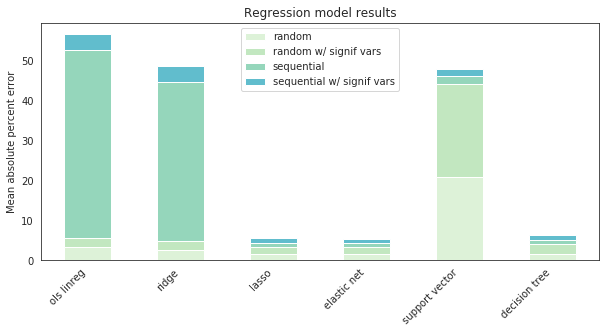

In [16]:
f, ax = plt.subplots(figsize=(10,5)) 
avged.drop(columns=["neural net"]).T.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=45,ha="right")
ax.set_ylabel("Mean absolute percent error")
ax.set_title("Regression model results")
plt.gcf().subplots_adjust(bottom=0.22)
f.savefig("figures/withtol/regression_all.png",dpi=300)